In [ ]:
#Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma
#is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths.
#A solution that can evaluate images and alert dermatologists about the presence of melanoma has the
# potential to reduce a lot of manual effort needed in diagnosis.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#Data Summary:

#The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

#The data set contains the following diseases:

#Actinic keratosis
#Basal cell carcinoma
#Dermatofibroma
#Melanoma
#Nevus
#Pigmented benign keratosis
#Seborrheic keratosis
#Squamous cell carcinoma
#Vascular lesion

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from pathlib import Path


In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/drive/MyDrive/CNN_assignment/Skin_Data_Store'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

1635
12


In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
## Write train dataset here
## Note use seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize the images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9635 files belonging to 9 classes.
Using 7708 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9635 files belonging to 9 classes.
Using 1927 files for validation.


In [11]:
## Write test dataset here
## Note use seed=123 while creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# We can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


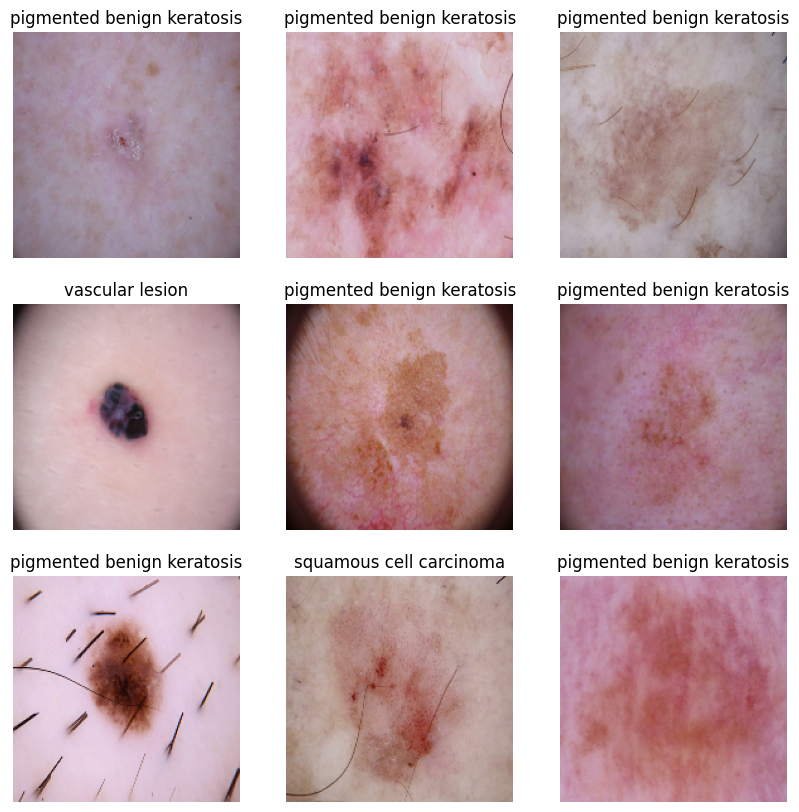

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#create the model
preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
#model code
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,318,689 (100.40 MB)

 Trainable params: 26,318,305 (100.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
#Todo, choose an appropirate optimiser and loss function for compiling the model
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,318,689 (100.40 MB)

 Trainable params: 26,318,305 (100.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
#train the model
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


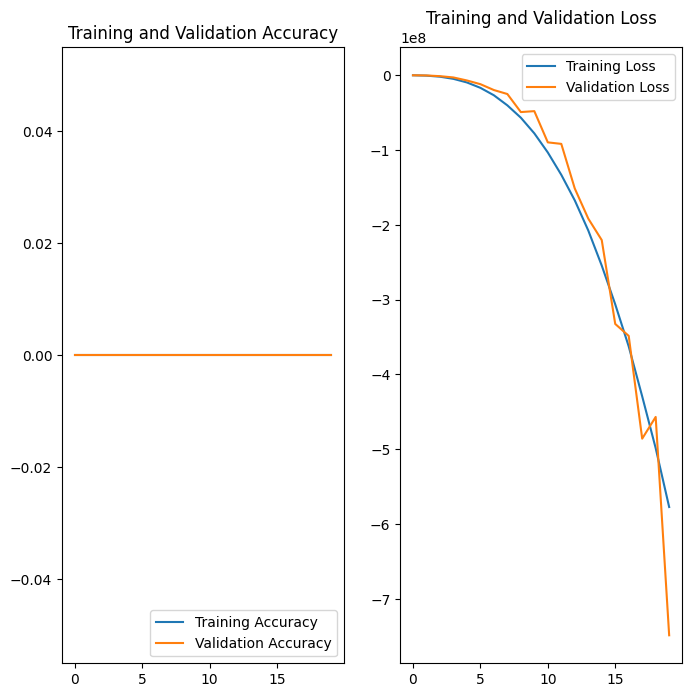

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.0000e+00 - loss: -743031808.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0000e+00 - loss: -753733632.0000
Accuracy:  0.0
Validation Accuracy:  0.0
Loss:  -739918784.0
Validation Loss -748654080.0


<Figure size 1000x1000 with 0 Axes>

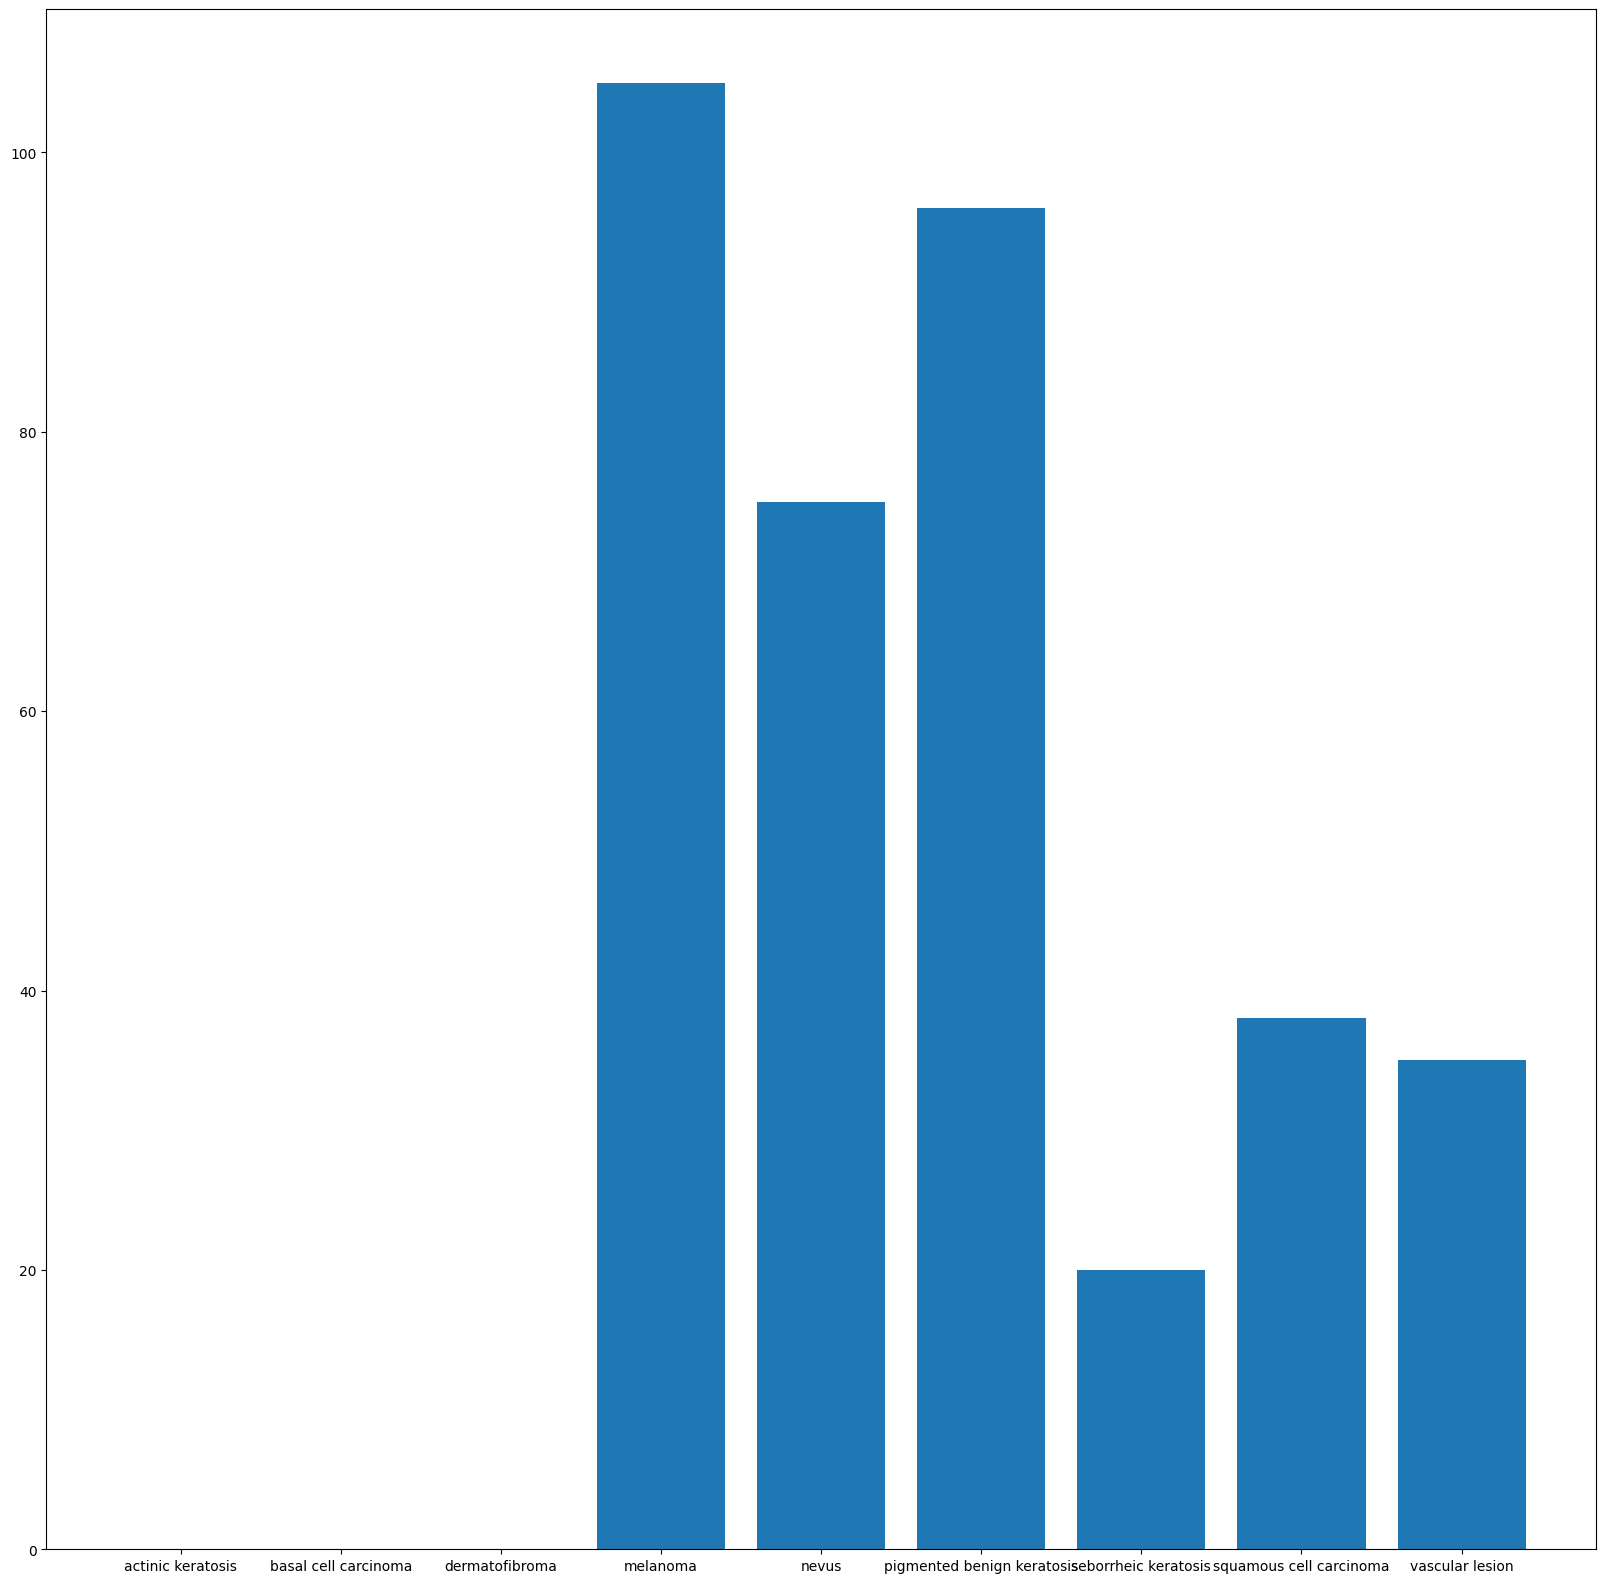

In [37]:
#visualizing the training dataset to see distribution of class
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [38]:
#We are using a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/)
#to add more samples across all classes so that none of the classes have very few samples.

!pip install Augmentor

In [88]:
#o use Augmentor, the following general procedure is followed:
#Instantiate a Pipeline object pointing to a directory containing your initial image data set.
#Define a number of operations to perform on this data set using your Pipeline object.
#Execute these operations by calling the Pipeline’s sample() method.

# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
import os

path_to_training_dataset = "/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/"
classes = os.listdir(path_to_training_dataset)

supported_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp'] # Add more extensions if needed.

for i in classes:
    full_path = path_to_training_dataset + i
    print(f"Processing path: {full_path}")

    if os.path.isdir(full_path):
        files = os.listdir(full_path)
        image_files = [f for f in files if os.path.splitext(f)[1].lower() in supported_extensions]

        if not image_files:
            print(f"Warning: No supported image files found in {full_path}")
        else:
            print(f"Found image files in {full_path}: {image_files}")
            p = Augmentor.Pipeline(full_path)
            p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
            p.sample(500)
    else:
        print(f"Warning: {full_path} is not a directory.")

Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis
Found image files in /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis: ['ISIC_0010863.jpg', 'ISIC_0010860.jpg', 'ISIC_0010872.jpg', 'ISIC_0010890.jpg', 'ISIC_0010810.jpg', 'ISIC_0010834.jpg', 'ISIC_0010878.jpg', 'ISIC_0010866.jpg', 'ISIC_0010876.jpg', 'ISIC_0010852.jpg', 'ISIC_0010883.jpg', 'ISIC_0010898.jpg', 'ISIC_0010862.jpg', 'ISIC_0010812.jpg', 'ISIC_0010900.jpg', 'ISIC_0011039.jpg', 'ISIC_0010978.jpg', 'ISIC_0010923.jpg', 'ISIC_0011043.jpg', 'ISIC_0010934.jpg', 'ISIC_0010982.jpg', 'ISIC_0010965.jpg', 'ISIC_0010917.jpg', 'ISIC_0011012.jpg', 'ISIC_0010979.jpg', 'ISIC_0010990.jpg', 'ISIC_0010938.jpg', 'ISIC_0010909.jpg', 'ISIC_0011007.jpg', 'ISIC_0011030.jpg', 'ISIC_0011042.jpg', 'ISIC_0010995.jpg', 'ISIC_0011013.jpg', 'ISIC_0010971.jpg', 'ISIC_0010993.jpg', 'ISIC_0011040.jpg', 'ISIC_0011032.jpg', 'ISIC_0010912.jpg', 'ISIC_0011031.jpg', 'ISIC_0010942.jpg'

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE707CB29D0>: 100%|██████████| 500/500 [00:47<00:00, 10.42 Samples/s]


Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/pigmented benign keratosis
Found image files in /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/pigmented benign keratosis: ['ISIC_0024477.jpg', 'ISIC_0024435.jpg', 'ISIC_0024446.jpg', 'ISIC_0024471.jpg', 'ISIC_0024489.jpg', 'ISIC_0024445.jpg', 'ISIC_0024453.jpg', 'ISIC_0024490.jpg', 'ISIC_0024612.jpg', 'ISIC_0024495.jpg', 'ISIC_0024672.jpg', 'ISIC_0024635.jpg', 'ISIC_0024711.jpg', 'ISIC_0024494.jpg', 'ISIC_0024705.jpg', 'ISIC_0024643.jpg', 'ISIC_0024696.jpg', 'ISIC_0024547.jpg', 'ISIC_0024741.jpg', 'ISIC_0024626.jpg', 'ISIC_0024592.jpg', 'ISIC_0024726.jpg', 'ISIC_0024708.jpg', 'ISIC_0024709.jpg', 'ISIC_0024676.jpg', 'ISIC_0024602.jpg', 'ISIC_0024498.jpg', 'ISIC_0024623.jpg', 'ISIC_0024740.jpg', 'ISIC_0024505.jpg', 'ISIC_0024581.jpg', 'ISIC_0024760.jpg', 'ISIC_0024825.jpg', 'ISIC_0024890.jpg', 'ISIC_0024850.jpg', 'ISIC_0024871.jpg', 'ISIC_0024910.jpg', 'ISIC_0024915.jpg', 'ISIC_0024748.jpg', 'ISIC_

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE707EE0F90>: 100%|██████████| 500/500 [00:23<00:00, 21.27 Samples/s]


Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/actinic keratosis
Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/nevus
Found image files in /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/nevus: ['ISIC_0000033.jpg', 'ISIC_0000024.jpg', 'ISIC_0000041.jpg', 'ISIC_0000020.jpg', 'ISIC_0000038.jpg', 'ISIC_0000050.jpg', 'ISIC_0000027.jpg', 'ISIC_0000052.jpg', 'ISIC_0000025.jpg', 'ISIC_0000021.jpg', 'ISIC_0000028.jpg', 'ISIC_0000037.jpg', 'ISIC_0000047.jpg', 'ISIC_0000042.jpg', 'ISIC_0000034.jpg', 'ISIC_0000053.jpg', 'ISIC_0000051.jpg', 'ISIC_0000039.jpg', 'ISIC_0000019.jpg', 'ISIC_0000023.jpg', 'ISIC_0000032.jpg', 'ISIC_0000079.jpg', 'ISIC_0000066.jpg', 'ISIC_0000061.jpg', 'ISIC_0000088.jpg', 'ISIC_0000082.jpg', 'ISIC_0000080.jpg', 'ISIC_0000087.jpg', 'ISIC_0000065.jpg', 'ISIC_0000064.jpg', 'ISIC_0000059.jpg', 'ISIC_0000058.jpg', 'ISIC_0000057.jpg', 'ISIC_0000083.jpg', 'ISIC_0000084.jpg', 'ISIC_0000063.jpg', 'ISIC_0000086

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7FE716D17D10>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/vascular lesion
Found image files in /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/vascular lesion: ['ISIC_0025197.jpg', 'ISIC_0024867.jpg', 'ISIC_0025244.jpg', 'ISIC_0024662.jpg', 'ISIC_0024706.jpg', 'ISIC_0024904.jpg', 'ISIC_0024747.jpg', 'ISIC_0024475.jpg', 'ISIC_0024669.jpg', 'ISIC_0026068.jpg', 'ISIC_0025680.jpg', 'ISIC_0025249.jpg', 'ISIC_0026163.jpg', 'ISIC_0025578.jpg', 'ISIC_0025606.jpg', 'ISIC_0025873.jpg', 'ISIC_0026349.jpg', 'ISIC_0025612.jpg', 'ISIC_0025452.jpg', 'ISIC_0025425.jpg', 'ISIC_0025596.jpg', 'ISIC_0026393.jpg', 'ISIC_0025924.jpg', 'ISIC_0025677.jpg', 'ISIC_0025707.jpg', 'ISIC_0025807.jpg', 'ISIC_0025599.jpg', 'ISIC_0026092.jpg', 'ISIC_0026456.jpg', 'ISIC_0025250.jpg', 'ISIC_0025321.jpg', 'ISIC_0026336.jpg', 'ISIC_0025628.jpg', 'ISIC_0026467.jpg', 'ISIC_0026713.jpg', 'ISIC_0027903.jpg', 'ISIC_0027563.jpg', 'ISIC_0027210.jpg', 'ISIC_0027672.jpg', 'ISIC_0027665.jpg', 'ISIC_00

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE714F42890>: 100%|██████████| 500/500 [00:23<00:00, 20.95 Samples/s]


Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/basal cell carcinoma
Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/dermatofibroma
Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/melanoma
Found image files in /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/melanoma: ['ISIC_0000149.jpg', 'ISIC_0000152.jpg', 'ISIC_0000153.jpg', 'ISIC_0000151.jpg', 'ISIC_0000144.jpg', 'ISIC_0000148.jpg', 'ISIC_0000139.jpg', 'ISIC_0000145.jpg', 'ISIC_0000146.jpg', 'ISIC_0000143.jpg', 'ISIC_0000150.jpg', 'ISIC_0000154.jpg', 'ISIC_0000142.jpg', 'ISIC_0000147.jpg', 'ISIC_0000141.jpg', 'ISIC_0000158.jpg', 'ISIC_0000162.jpg', 'ISIC_0000173.jpg', 'ISIC_0000176.jpg', 'ISIC_0000156.jpg', 'ISIC_0000169.jpg', 'ISIC_0000279.jpg', 'ISIC_0000175.jpg', 'ISIC_0000168.jpg', 'ISIC_0000170.jpg', 'ISIC_0000166.jpg', 'ISIC_0000171.jpg', 'ISIC_0000164.jpg', 'ISIC_0000160.jpg', 'ISIC_0000165.jpg', 'ISIC_0000174.jpg', 'ISIC_000015

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FE71F90F8D0>: 100%|██████████| 500/500 [01:45<00:00,  4.76 Samples/s]


Processing path: /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/squamous cell carcinoma
Found image files in /content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/squamous cell carcinoma: ['ISIC_0025029.jpg', 'ISIC_0025182.jpg', 'ISIC_0025358.jpg', 'ISIC_0025069.jpg', 'ISIC_0025130.jpg', 'ISIC_0024710.jpg', 'ISIC_0025196.jpg', 'ISIC_0025089.jpg', 'ISIC_0025178.jpg', 'ISIC_0024923.jpg', 'ISIC_0025331.jpg', 'ISIC_0025264.jpg', 'ISIC_0024843.jpg', 'ISIC_0024925.jpg', 'ISIC_0025247.jpg', 'ISIC_0025350.jpg', 'ISIC_0024946.jpg', 'ISIC_0025948.jpg', 'ISIC_0026327.jpg', 'ISIC_0025471.jpg', 'ISIC_0025808.jpg', 'ISIC_0026388.jpg', 'ISIC_0026138.jpg', 'ISIC_0026083.jpg', 'ISIC_0026178.jpg', 'ISIC_0025539.jpg', 'ISIC_0026319.jpg', 'ISIC_0025577.jpg', 'ISIC_0025790.jpg', 'ISIC_0025831.jpg', 'ISIC_0026132.jpg', 'ISIC_0026152.jpg', 'ISIC_0025696.jpg', 'ISIC_0025411.jpg', 'ISIC_0026203.jpg', 'ISIC_0026100.jpg', 'ISIC_0025637.jpg', 'ISIC_0025811.jpg', 'ISIC_0026206.jpg', 'ISIC_002571

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE714E96390>: 100%|██████████| 500/500 [00:24<00:00, 20.54 Samples/s]


In [96]:
#total count of augmented images.
data_dir_train = "/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/" #or whatever your path is.

# Total count of augmented images.
image_count_train = len(list(Path(data_dir_train).glob('*/output/*.jpg')))
print(image_count_train)

8000


In [97]:
#the distribution of augmented data after adding new images to the original training data
import os
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_86f01448-d895-463f-a84d-f09d8aa94797.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_45572f6f-69e3-4223-a790-487b5377fe22.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010812.jpg_adfa7808-efe7-45e6-b7ff-024611aed897.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_3a2f3644-d980-45bd-a051-85b236588252.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_364330a8-802e-4f2d-bb79-4e55032499b1.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train/seborrheic keratosis/output/seborrheic

In [98]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [149]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [150]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2


In [101]:
new_df['Label'].value_counts()

,count
Label,
seborrheic keratosis,2000
pigmented benign keratosis,2000
nevus,1000
vascular lesion,1000
melanoma,1000
squamous cell carcinoma,1000


In [151]:
#Train the model on the data created using Augmentor
batch_size = 32
img_height = 180
img_width = 180

In [137]:
pip install --upgrade tensorflow

In [159]:
# Create a training dataset
data_dir_train = "/content/drive/MyDrive/CNN_assignment/Skin_Data_Store/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical' #ensure this is set.
)


Found 9635 files belonging to 9 classes.
Using 7708 files for training.


In [160]:
#create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical' #ensure this is set.
)

Found 9635 files belonging to 9 classes.
Using 1927 files for validation.


In [161]:
#create a model using normalization
#create a model using normalization
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax')) # Change the output layer to 9 units with softmax

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

In [166]:
#compile the model by Choose optimizer and loss function appropriately
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# If you have 9 classes then use categorical_crossentropy
# for binary classification, you can use binary_crossentropy
model.compile(optimizer='adam',
              loss='categorical_crossentropy', #change the loss function.
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [2]:
#train the model
epochs = 20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])



NameError: name 'ReduceLROnPlateau' is not defined

In [ ]:
#Visualize the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()